# Tests for Hierarchical Models

## Test 1: Modeling Heteroskedasticity

Data: 
- Cluster number: category
- X: numeric
- Y: numeric

Model:

$$
\beta \sim N(0, 5)  \\
\sigma_{j} \sim \text{HalfNormal}(3) \\
y \sim N(X \beta, \sigma_j^2)
$$

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random

from scipy.stats import halfnorm

In [28]:
## simulate data:

clusters = np.random.randint(3, size = 100)
x = np.random.normal(size = 100)
beta_true = 3.5

cluster_sigmas = np.array([2., 4.5, 1.2])
sigma = 2.

y = beta_true * x + halfnorm.rvs(loc=cluster_sigmas[clusters]) + np.random.normal(scale = sigma)

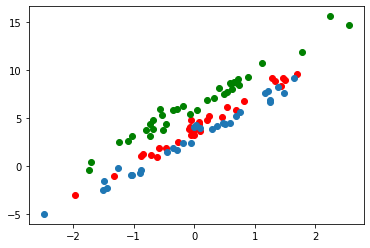

In [36]:
plt.scatter(x[clusters == 0], y[clusters == 0], color = "red")
plt.scatter(x[clusters == 1], y[clusters == 1], color = "green")
plt.scatter(x[clusters == 2], y[clusters == 2]);

In [49]:
def hierarchical_model (x, clusters, y=None):
    num_clusters = len(np.unique(clusters))
    beta = numpyro.sample("beta", dist.Normal(0, 5))
    sigma = numpyro.sample("sigma", dist.HalfNormal(3.))
    cluster_hyper = numpyro.sample("cluster_mu", dist.Normal(0, 1.))
    with numpyro.plate("num_clusters", num_clusters):
        cluster_i = numpyro.sample("cluster", dist.Normal(cluster_hyper, 1))
    numpyro.sample("obs", dist.Normal(beta * x + cluster_i[clusters], sigma), obs = y)

In [50]:
nuts_kernel = NUTS(hierarchical_model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, 
         x, 
         clusters, y=y)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:03<00:00, 1193.61it/s, 3 steps of size 7.34e-01. acc. prob=0.90]


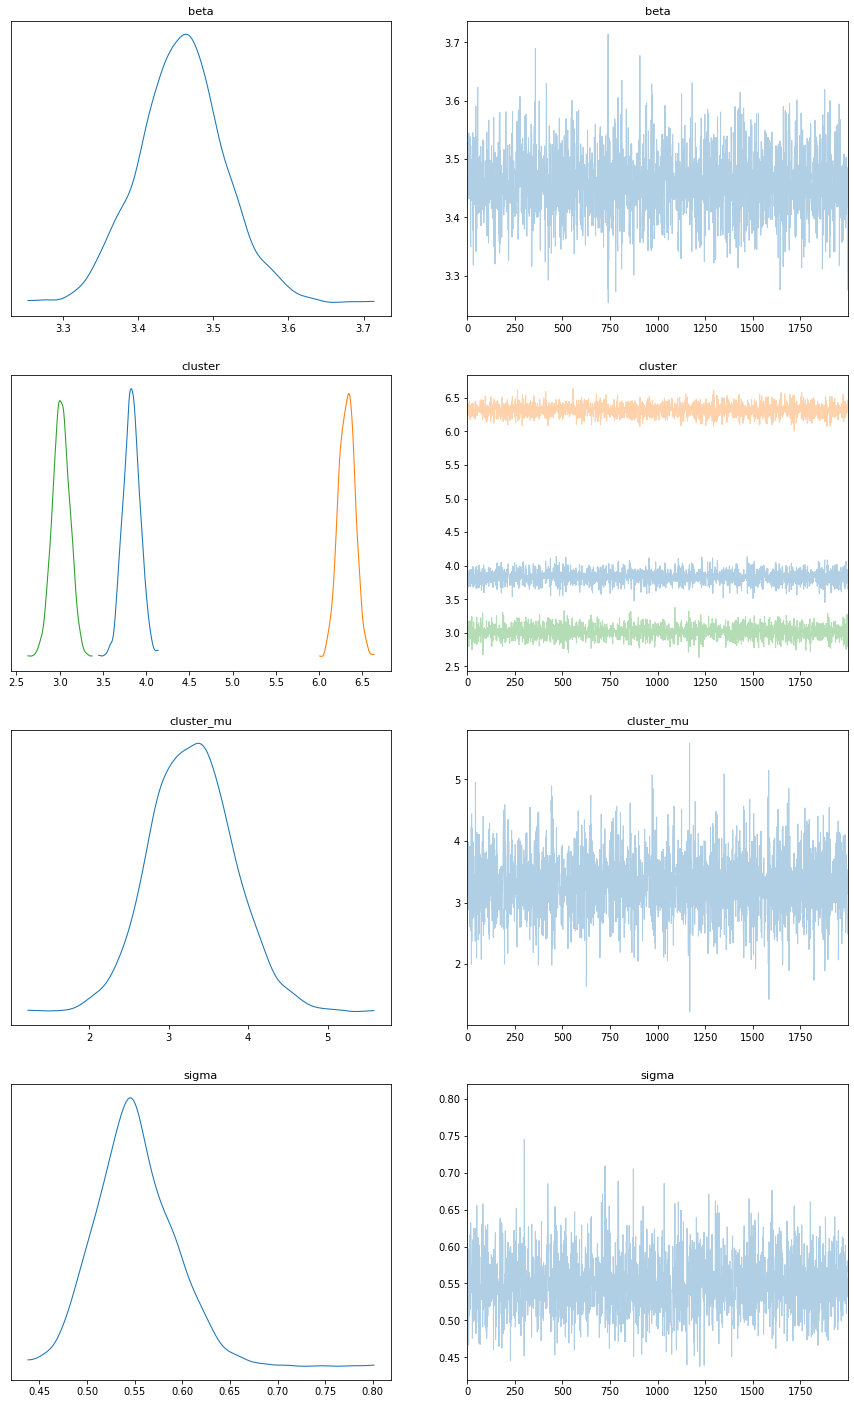

In [51]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 25));